In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import math as m
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler


# prep(df) function
- **information:**

    getting the name of the column that holds the policy information (required to be the last column), as pol_col

    getting the name of the column with the identity key (required to be the first column), as id_col

    cat_col is the number of categorical columns

    pol_columns is a list of all the policy types found in the dataset

- **new columns:**

    create column pol_count with value 1 for all rows, group by the id_col and sum the values to create temp_df. This counts the occurances of each id in the dataset, which is a count of the number of policies each id holds. Drop pol_count and merge the temp_df by left join to the original dataset, new column is called pol_count.

    Create a new temp_df that groups the data by the id_col makes a set of the policy column values, ie. a unique list of the policies of each id, named 'set of policies'. Merge this to the orginal dataset using left join.

    The size of each set is the number of unique policy types each id has, 'no unique products'
    
- **aggregation:**

    split the data into numerical and categorical data (num_df and cat_df respectively). 
    
    Where num_df is all columns of datatypes 'float64' and 'int64', filling N/A values with 0.0 (N/A values would cause problem in matrix multiplication when calculating similarity scores). This data is aggregated by summing the values where they are not unique (eg. premium for policy) and if unique then take that value (eg. age). This is under assumption that the policy data (new records added over time as new policies are taken out) and the customer data are stored seperately and merged (ie. customer data is at one point in time for all policy entries)

    Where cat_df is all columns of datatypes 'object','bool' and 'category'. This gets hot-one encoded. This is aggregated by grouping by the id_col and summing the hot-one encoded data and replacing values > 0 with 1. (In the case where a client has multiple policies, if they have the same flag multiple times for the same column it will count the flag for each occurance of the client, so replacing values > 0 returns it to a flag. eg. someone has 2 policies, so their has_dependant flag will show as 2)

    Building aggregated df: select only the id_col and 'set of policies' from the orginal dataframe and drop duplicate rows (ie. one row for each id with all policies in 'set of policies' column). Merge the num_df and cat_df using inner join on the id_col. Join this to the "set of policies" df using inner join on the id_col. Now we have the id column, all the hot-one encoded data, numerical data and the set of policies in one dataframe, all aggregated (ie. one row view of each client)


In [ ]:
def prep(df):
    pol_col = df.columns[-1] #name of policy column
    id_col = df.columns[0] #name of id column

     # Count the number of policies per user
    df['pol_count'] = 1
    temp_df = df.groupby(id_col)['pol_count'].sum().reset_index()
    # Merge policy count back into the original DataFrame
    df = df.drop(columns={'pol_count'})
    df = pd.merge(df, temp_df, 
                         on=id_col, 
                         how='left')
    
    # Create a set of unique policies per user
    temp_df = pd.DataFrame(df.groupby(id_col)[pol_col].apply(set))
    temp_df = temp_df.rename(columns={pol_col: 'set of policies'})  #column containing a set of all policy types client has
    df = pd.merge(df, temp_df,on = id_col, how = 'left')

    # Count unique policy types per user
    df['no unique products'] = df['set of policies'].apply(lambda x: len(x) if isinstance(x, set) else 0)

    # Process numerical features
    num_df = df.iloc[:,1:].select_dtypes(include=['float64','int64']).copy() #creating numerical features df
    num_df.insert(0,id_col,df[id_col])
    num_df.iloc[:,1:] = num_df.iloc[:,1:].fillna(0.0)

    def custom_agg(series): #if the numerical value is the same accross all rows per client don't take sum, take value (eg, how many policies), otherwise take sum (eg. premium for policy)
        return series.iloc[0] if len(series.unique()) == 1 else series.sum()
    # Group by 'id' and apply the aggregation
    num_df = num_df.groupby(id_col).agg({col: custom_agg for col in num_df.columns[1:]}).reset_index()

    #creating categorical feature df
    cat_df = df.iloc[:,1:-2].select_dtypes(include=['object','bool','category']).copy()
    cat_df.insert(0,id_col,df[id_col])
    cat_df = pd.get_dummies(cat_df.iloc[:,1:],columns = cat_df.iloc[:,1:].columns, dtype=int)
    cat_df.insert(0,id_col,df[id_col])
    cat_df = cat_df.groupby(id_col).sum()
    cat_df = cat_df[cat_df.columns].map(lambda x: 1 if x > 0 else 0)

    df = df[[id_col, 'set of policies']]
    # Convert set columns to sorted tuples so they're hashable and comparable
    df['set of policies'] = df['set of policies'].apply(
    lambda x: tuple(sorted(x)) if isinstance(x, set) else tuple())
    df = df.drop_duplicates()
    df['set of policies'] = df['set of policies'].apply(set)

    #merging categorical and numerical aggregated data
    agg_df = pd.merge(cat_df, num_df,on = id_col, how = 'inner') #aggregated dataframe
    agg_df = pd.merge(agg_df, df,on = id_col, how = 'inner')
    cat_col = len(cat_df.columns) #how many categorical columns there are

    pol_columns = [col for col in agg_df.columns if col.startswith(pol_col)] #list of all policy columns

    return pol_columns,cat_col, agg_df,id_col
'''returns policy columns names, number of categorical columns, the aggregated dataframe and the id column name'''


# Cosine similarity

Cosine similarity uses the cosine of the angle between two vectors to measure how similar these two vectors are. This similarity measure is suitable for numerical variables or binary categorical variables.


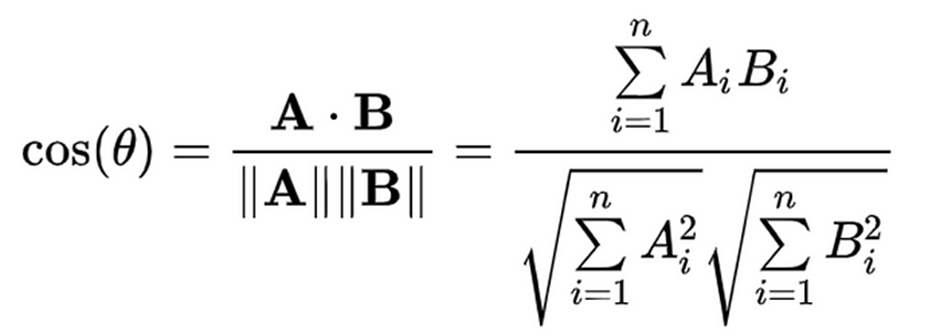

The function receives the matrix of numerical data (columns) for each id (rows), the norm to use and the numerical features' weigthings.

 The cosine similarity can be performed as follows using matrices: normalize the matrix using norm n, (ie, normalizing the vectors that correspond to each id), then np.matmul of the matrix and it's transform performs the dot product between all vector pairs, this gives us the cosine similarity between all id pairs (making diagonal 0 for similarity of an id with itself).
 
  The weighting vector w applies the weighting to each numerical feature by multiplying it to A but not the transform before the matrix multiplication.

In [ ]:
''' 
Cosine similairty function using matrices to find the cosine similarity between all id pairs based on numerical features. weighting vector is used to weight the features.'''
def weighted_cosine_similarity(A,n, w): #w is the weighting vector
    #normalise the matrix
    A = normalize(A, axis=1, norm = n)
    
    #matrix multiplication of matrix and it's transpose
    sim_matrix = np.matmul(w*A,A.T)
    del A
    
    #make diagonals zero
    np.fill_diagonal(sim_matrix, 0)
    
    return sim_matrix

# Jaccard similarity

Jaccard similarity uses the intersection and union between two sets to measure how similar these two sets are. This similarity measure is suitable for categorical variables.

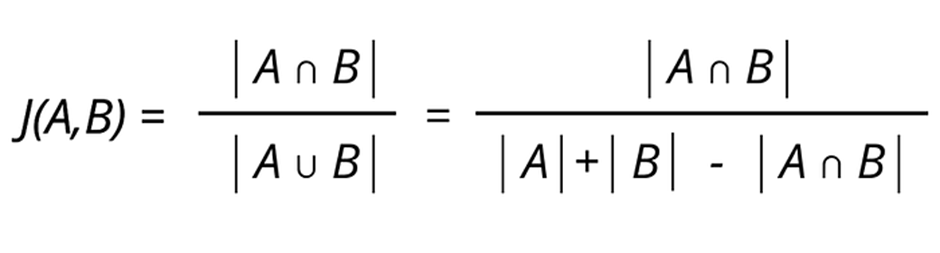

In our case the sets represent the rows of categorical attributes that have been hot-one encoded.

Using tensor flow inproves performance of this function.

First we get the intersection of the hot-one encoded vectors across all categorical attributes, which can be determined using the dot product. In the same way as with cosine similarity we apply the categorical weigthings.

For the union the row_sums give us the size of the sets for each id in the comparison, the weigthing is applied here. The sum of both sets' sizes minus the intersection is the union.

Divide the intersection by union for the jaccard similarity, make diagonal zero.

In [ ]:
'''Jaccard similairty function to determine the jaccard similarity score between all id pairs using categorical features. Weighting vector is used to weight the features.'''

def weighted_jaccard_similarity(feature_matrix, w):  #w is the weighting vector
     
     # Ensure the feature matrix is a TensorFlow tensor
     feature_matrix = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
     # Compute the intersection (dot product)
     intersection = tf.matmul(w*feature_matrix, feature_matrix, transpose_b=True)
     # Compute the sum of 1s per row
     row_sums = tf.reduce_sum(w*feature_matrix, axis=1)
     # Compute the union
     union = row_sums[:, tf.newaxis] + row_sums - intersection
     # Avoid division by zero by setting union to at least 1
     union = tf.clip_by_value(union,clip_value_min=1.0, clip_value_max=tf.reduce_max(union))
     # Compute the Jaccard similarity matrix
     jaccard_sim_matrix = intersection / union
     del feature_matrix,intersection,union,row_sums
     
     # Set diagonal elements to 0
     jaccard_sim_matrix = jaccard_sim_matrix - tf.linalg.diag(tf.linalg.diag_part(jaccard_sim_matrix))
     
     return jaccard_sim_matrix

# final similarity matrix

This function receives: aggregated dataframe, norm for cosine similarity, the number of categorical columns, the cosine similarity features' weighting vector, the jaccard similarity features' weighting vector

Adding the similarities based on numerical and categorical data together by equal weight for the final similarity scores between all ids in the dataset.

In [ ]:
'''Function to combine the cosine and jaccard similarities using some weighting (num:cat for numerical and categorical features)'''

def similarity_matrix(df,norm,cat_col,cw,jw): #dataframe with cat and num features, norm used for cosine, number of categorical columns, cosine weighting, jaccard weighting
    
    sim_matrix =0.5*weighted_cosine_similarity(df.iloc[:,cat_col:].values,norm,cw) #similarity based on numerical info
    sim_matrix = sim_matrix + 0.5*weighted_jaccard_similarity(df.iloc[:,0:cat_col],jw) #add similarity based on categorical info
    
    return sim_matrix

# recommender function

The function receives: the number of recommendations to provide, the cosine similarity features' weighting vector, the jaccard similarity features' weighting vector, list of all policies, the number of categorical columns, the aggregated dataset.

Using the similarity_matrix function to calculate the similairty scores.

Creates a dataframe with only policy indicators, ie aggregated, hot-one encoded data or the policy columns, policy_ind_df. Creates the inverse of this as well, policy_ind_inverse_df. 

The recommendation scores are calculated as the dot product between the similarity matrix and the policy_ind_df, this is normalized usind MinMaxScaler to get scores between 0-1. The scores are then multiplied with the inverse policy indicator matrix to make the score 0 for policies the id already has, and keep the recommendation score for policies the id does not have.

Then the top n (recs specifies n) highest scoring policies and their scores are appended to the dataframe for each id and returns this, rec_df




In [ ]:
'''Calculate the similarity matrix then the recommendation scores (dot product between the similarity matrix and the policy indicators), normalizing these scores using the Min-Max normalization method '''
def recommender(recs, cw, jw,pol_columns,cat_col, agg_df):


    sim_matrix = similarity_matrix(agg_df.copy(),'l2',cat_col,cw,jw)
    policy_ind_df = agg_df[pol_columns]
    policy_ind_inverse_df = pd.DataFrame(np.logical_xor(policy_ind_df.values,1).astype(int),columns=policy_ind_df.columns, index=policy_ind_df.index)
    scores = np.dot(sim_matrix,policy_ind_df)#recommendation score, sum of similarities for products users have (dot product)
    scaler = MinMaxScaler()
    scores_scaled_r = scaler.fit(scores)
    scores_scaled_r = scaler.transform(scores) #apply normalization (MinMax)
    scores_scaled = scores_scaled_r*policy_ind_inverse_df #make score zero for products user already has
    scores_df = pd.DataFrame(scores_scaled,columns=policy_ind_df.columns, index=policy_ind_df.index)
    new_col = {}
    del policy_ind_df,policy_ind_inverse_df,scores,scores_scaled,scores_scaled_r

    #adding recommendations to the aggregated dataframe
    for i in range(1, recs+1, 1):
        new_col[f"no.{i} most rec product"] = []
        new_col[f"no.{i} product score"] = []
    for n in agg_df.index:

        sorted = scores_df.loc[n].sort_values()
        rec_sc = np.array(sorted.values[-recs:])
        prod = np.array(sorted.index[-recs:])
        for i in range(recs-1,-1,-1):
            j = recs-i
            new_col[f"no.{j} most rec product"].append(prod[i])
            new_col[f"no.{j} product score"].append(rec_sc[i])

    rec_df = pd.DataFrame(agg_df.index)
    rec_df = rec_df.assign(**new_col)


    for r in range(1,recs+1,1):
        rec_df[f'no.{r} most rec product'] = rec_df[f'no.{r} most rec product'].str.replace('pol_type_desc_', '') #cleaning up

    return rec_df

# MRR scoring

MRR is a measure of how the quality of recommendations, it considers the position of the first relevant item in the ranked list. This means that if the first most relevant product is recommended first, then the model performs best, and the later that product is recommended (ie. the lower it's rank) the worse the model’s MRR score. Eg. If the model recommends the first relevant product at rank r, then the MRR score is 1/r. 

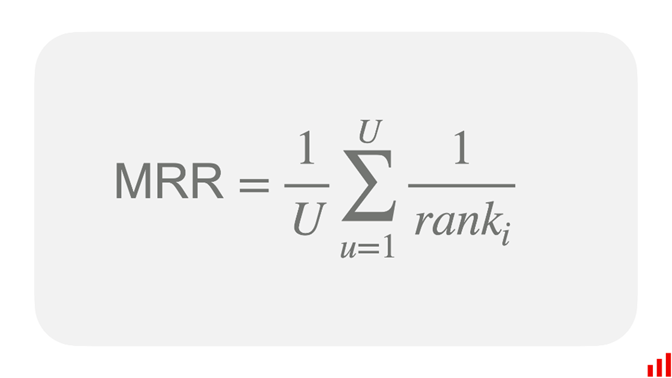

This function receives the dataframe with orginal data and the recommendations appended and the name of the column with the set of new policies.

It calculated the mrr 3 and 4 score and appends it to the dataframe.

If the n most recommended policy is in the set of policies the id has (ie. intersection of sets == 1), then it receives its score based on n.

The dataframe for this comes from backtesting data, see next function for expanation

In [ ]:
'''Function to calculate the mean reciprical rank score based on the recommendations and the new product taken out.'''

def MRR(df,pol_col): #scoring based on where new product sits in regards to recommendations, mean reciprical rank_3 and 4
 
    conditions = [df.apply(lambda row: len({row['no.1 most rec product']}.intersection(row[pol_col])) ,axis=1) == 1,
                  df.apply(lambda row: len({row['no.2 most rec product']}.intersection(row[pol_col])) ,axis=1) == 1, 
                  df.apply(lambda row: len({row['no.3 most rec product']}.intersection(row[pol_col])) ,axis=1) ==1]
    scores = [1, 0.66, 0.33]

    df['MRR_3_score'] = np.select(conditions, scores, default=0)

    df['MRR_4_score'] = [
    1 if f_rec in s else 0.75 if s_rec in s else 0.5 if t_rec in s else 0.25 if fr_rec in s else 0
    for f_rec,s_rec,t_rec,fr_rec,s in zip(df['no.1 most rec product'],df['no.2 most rec product'],df['no.3 most rec product'],df['no.4 most rec product'],df['newest_product'])]

    return df

'''df is the dataframe given with MRR scores appended'''

# Backtesting

This process involves training the recommender system on historical data up to a specific point in time and then assessing its recommendations against actual client behaviour observed in a subsequent period.

Specifically, our back testing procedure is as follows:

**Historical Data Snapshot:** We select a cut-off date, for example, April 1, 2024. The recommender system is then trained using only policy data where the first premium was paid on or before this date, meaning only policies "active" as of April 1, 2024, are included.

**Identify Test Cases:** We then identify clients who took out new policies that became active after the training data cut-off (e.g., between April 1, 2024) and the current date .
Generate and Compare Recommendations: Using the model trained on the April 1, 2024 data, we generate recommendations for these identified clients.

**Performance Evaluation:** Finally, we compare these historical recommendations to the actual new policies these clients subsequently purchased. This comparison allows us to gauge the quality and predictive accuracy of our recommender system.

This backtesting approach effectively simulates how the model would have performed in the past, providing valuable insights into its real-world effectiveness.


This function takes the prepared data for the back-dated dataset, Dx, the prepared data for the most up-to-date dataset, Dc, the ids that have been trained on and gone through the model, the name of the id column and the trained dataset (subset of back-dated data) that has been through the recommender model and has recommendations appended, Rx.

Filter Dx and Dc on the data used for training by inner join on id_col with pids (the list of ids that were trained on) to get Dx_s and Dc_s then merging these feiltered datasets but only selecting columns 'no unique products','set of policies','pol_count' from Dc_s to get df_j.

Creating flags for if id has an increase in the number of policies between the back-dated set and the up-to-date dataset and for if the id has a new type of policy between that time period. Using the second flag to get a set of the new policy types an id acquired, then filtering on this to have a data set of ids that acquired new policy types in the time period, df_new.

Merging df_new to the trained dataset with recommendations Rx, to only append the recommendations for each id.

Calculating the MRR scores and getting it appended to the df using mrr function.







In [ ]:
'''This function applies the backtesting logic. Comparing the back-dated data to the current data,
 flagging if members have new policies and if members have a new product. Filtering on members with new products, 
 adding their product recommendations and scoring using Mean Reciprocal Rank (comparing real new products taken out vs recommendations)'''

def backtesting(Dx,Dc,pids,id_col,Rx):
    
    Dx_s = pd.merge(Dx,pids,on=id_col,how='inner') #selecting records that were trained on
    Dc_s = pd.merge(Dc,pids,on=id_col,how='inner') #getting current info for the training pids
    df_j = pd.merge(Dx_s,Dc_s[[id_col,'no unique products','set of policies','pol_count']],
                    on = id_col,
                    how = 'inner', suffixes=('_x', '_c'))

    #flag whether client has new policy and flag for if client has new product (bc client can take ut new policy of product they already have)
    df_j['new_policy_flag'] = (df_j['pol_count_x'] < df_j['pol_count_c']).astype(int)
    df_j['new_product_flag'] = (df_j['no unique products_x'] < df_j['no unique products_c']).astype(int)
    #getting the name of the new product
    df_j['newest_product'] = [c-x if f == 1 else 0 
                              for x,c,f in zip(df_j['set of policies_x'],df_j['set of policies_c'],df_j['new_product_flag'])]

    df_new = df_j[df_j['newest_product'] != 0] #dataframe of users with new products
    del df_j
    df_new = pd.merge(df_new,Rx[[id_col,'no.1 most rec product','no.1 product score','no.2 most rec product','no.2 product score','no.3 most rec product','no.3 product score','no.4 most rec product','no.4 product score','no.5 most rec product','no.5 product score','no.6 most rec product','no.6 product score']],
                      on = id_col, 
                      how='inner') #include recommendations
    
    #scoring
    df_new = MRR(df_new,'newest_product')

    return df_new
'''returning dataframe with training data, recommendations, policy info and recommendation scores'''


# k_folds() function for scoring model with k folds

This function takes some weightings and applies it across multiple folds, back-tests and scores each fold, retur the latest fold's dataframe and the mrr_4 score for each fold in a list.

The function receives: the unprepared back-dated data df_x, the prepared back-dated data Dx, the prepared current/up-to-date data Dc, and the number of recommedations to output and the size for the folds.

Runs prep() function on df_x to get training data, dropping columns to prepare for being inputted to recommender. Sets equal weightings of 1 for each feature, can be modified if better weigtings are known. For number of folds specified, runs the recommender on a sample training data (fold) and backtests this, appending the score to a list.

In [ ]:
'''runs k folds of training sets (some sample of backdated data) through recommender, and backtests each.
 If best weigthings are known and no optimization is necessary, use this function instead of k_folds_optimization.'''
def k_folds(df_x,k,Dx,Dc,recs,fold_size):

    scores = []

    #training data (subset of backdated data)
    pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy().drop(columns = ['businessentityname', 'trn_grp_desc', 'prod_house_desc',
           'prod_tbl_grp_desc', 'psm_opt_desc',  'sky_pol_type_desc', 'product_desc', 'prod_tbl_cd', 'pa_sts_desc','business_only_indicator', 
           'death_benefit_indicator','pps_full_flag'])) 
    #pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy())
    #columns dropped because of previous model's target leakage, but model performs better without these columns...
    #Maybe investigate effect of keeping/dropping certain columns
    Rx = Rx.drop(columns = ['pol_count','no unique products','set of policies']).set_index(id_col)
   
    cw = (1)*np.array([1] *(Rx.shape[1] -cat_col_r)) 
    jw = (1)*np.array([1] *(cat_col_r)) #include policy info

    for i in range(k):
    
        Rx_f = recommender(recs, cw, jw,pol_columns_r,cat_col_r,Rx.copy().sample(fold_size) ) #recommender function to get recommendations for the fold sample
        
        pids = Rx_f[id_col].drop_duplicates() #pids that have recommendations, training pids

        df_new = backtesting(Dx,Dc,pids,id_col,Rx_f.copy()) #backtesting on the current fold

        scores.append(np.mean(df_new['MRR_4_score']))
        
    return df_new,scores

'''returns the latest fold's dataframe with recs and the ave MRR_4 model score for all folds'''


# Gradient descent for optimizing the weightings

A gradient descent algorithm is employed to find the optimal weightings. Since our model doesn't use a traditional loss function, we define "loss" as 1 - model_score. The gradient descent thus seeks to minimize this value, effectively maximizing the model_score.
The algorithm iteratively adjusts the feature weights to achieve the highest possible model score.


**gradient_descent()** function receives: cosine weightings vector, jaccard weightings vector, the policy columns, number of categorical columns, the training data, prepared the back-dated data, the prepared up-to-date data, the id column, the gradient descent step size.

First the recommender is run on the training data and the results backtested to get the mrr-4 score.

Then it calls the gradient function to get the gradient for the "loss" based on the chnage in weightings, to use to update the weigthings.


**gradient()** function receives: cosine weightings vector, jaccard weightings vector, the gradient descent step size, the training data, the policy columns, number of categorical columns,  the id column, prepared the back-dated data, the prepared up-to-date data, the ids that were trained on

The function uses the stepsize to step each weighting in the weighting vectors and record the change in the model performance. It steps one weight, runs the recommender, backtests and scores the model, calculates and stores the "loss". The list of all the "loss" values are returned.


In [ ]:
'''Calculated the gradient of the loss graph for step in each weighting to find change of loss for gradient descent update formula'''
def gradient(cw,jw,step,Rx, pol_columns, cat_col, id_col,Dx,Dc,pids):
  loss_step = []
  for i in range(0,len(cw)):
      cw_step = list(cw)
      cw_step[i] += step

      recs_df = recommender(6, cw_step, jw,pol_columns,cat_col,Rx.copy())
      df_new = backtesting(Dx,Dc,pids,id_col,recs_df)
      mod_score_step = np.mean(df_new['MRR_4_score'])
      del df_new

      loss_step.append(1-mod_score_step) #1-score to mimic log loss where 0 means perfect performing model
      
  for i in range(0,len(jw)):
      jw_step = list(jw)
      jw_step[i] += step

      recs_df = recommender(6, cw, jw_step,pol_columns,cat_col,Rx.copy())
      df_new = backtesting(Dx,Dc,pids,id_col,recs_df)
      mod_score_step = np.mean(df_new['MRR_4_score'])
      del df_new
      
      
      loss_step.append(1-mod_score_step)
      

  return np.array(loss_step)
'''returns the change in loss accross all weightings'''

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
'''update for weighting with gradient descent method using the change in "loss" from the gradient function'''
def gradient_descent( cw, jw,pol_columns_r,cat_col_r,Rx,Dx,Dc,id_col,step):
    recs_df = recommender(6, cw, jw,pol_columns_r,cat_col_r,Rx.copy())
    pids = recs_df[id_col].drop_duplicates() #pids that have recommendations, training pids

    df_new = backtesting(Dx,Dc,pids,id_col,recs_df) #backtesting on the current fold

    mod_score = np.mean(df_new['MRR_4_score'])
    del df_new
    
    loss_step = gradient(cw,jw,step,Rx, pol_columns_r, cat_col_r, id_col,Dx,Dc,pids) #loss for each weighting
    d_loss = loss_step - np.full_like(loss_step, 1- mod_score) #differnce in loss

    cw_next = cw - d_loss[0:len(cw)]
    jw_next = jw - d_loss[len(cw):]
    
    return cw_next, jw_next, np.linalg.norm(d_loss)
    '''return the updated weigtings and the loss difference'''

# Optimizing the weigthings

k_fold_optimization runs the gradient descent optimization to find the weighting vectors that produce the best performing model.

The k_fold_optimization function receives: the unprepared back-dated dataset, the number of folds to use, the prepared backdated data, the prepared up-to-date data, number of recommmendations, step size for gradient descent and purpose (this is for step-size evaluation purposes), the fold sample size to run optimization on and the fold size for final model evaluation on the fold.

It prepares the back-dated data to create the training dataset, for each fold, specifies the iterations and threshold, initializes the weightings (equal weightings), takes a sample of the training data that the gradient descent is then applied to to find the optimal weightings based on this sample, the it runs the model with these weightings on the whole fold to get a final scoring for the fold and its found optimal weightings. The scores and weightings are collected and returned



In [ ]:
'''runs k folds of training sets (some sample of backdated data) through recommender, and backtests each'''
def k_folds_optimization(df_x,k,Dx,Dc,recs,step,purpose,fold_sample_size, fold_size):

    scores = [] #list of scores for each fold
    cw_weightings = [] #list of cosine weightings used for each fold
    jw_weigtings = [] #list of jaccard weightings used for each fold

    #training data (subset of backdated data)
    pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy().drop(columns = ['businessentityname', 'trn_grp_desc', 'prod_house_desc',
           'prod_tbl_grp_desc', 'psm_opt_desc',  'sky_pol_type_desc', 'product_desc', 'prod_tbl_cd', 'pa_sts_desc','business_only_indicator', 
           'death_benefit_indicator','pps_full_flag'])) 
    #pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy())
    #columns dropped because of previous model's target leakage, but model performs better without these columns...
    #Maybe investigate effect of keeping/dropping certain columns

    Rx = Rx.drop(columns = ['pol_count','no unique products','set of policies']).set_index(id_col)
    
    for i in range(k):
        e = 0.1 #error value for gradient descent
        t = 40 #to avoid infinite loop

        Rx_s = Rx.copy().sample(fold_sample_size) #the fold of data used for optimization

        cw = (1)*np.array([1] *(Rx_s.shape[1] -cat_col_r)) 
        jw = (1)*np.array([1] *(cat_col_r)) #include policy info

        #--------------------optimizations of weightings------------------
        #process of finding optimal weightings on fold sample

        while e > 0.065 and t>0: #as e tend to zero the change in the "loss" value tends to zero
            cw,jw,e = gradient_descent(cw,jw,pol_columns_r,cat_col_r,Rx_s,Dx,Dc,id_col,step) 
            print(e, t, i)
            t = t-1 

        #------------------------------------------------------------------------
        #found optimal weigthings applied to the full fold for final fold scoring
        Rx_f = recommender(recs, cw, jw,pol_columns_r,cat_col_r,Rx.copy().sample(fold_size) )
        pids = Rx_f[id_col].drop_duplicates() #pids that have recommendations, training pids

        df_new = backtesting(Dx,Dc,pids,id_col,Rx_f.copy())

        scores.append(np.mean(df_new['MRR_4_score']))
        cw_weightings.append(cw)
        jw_weigtings.append(jw)

    if purpose == 'step size evaluation':
        return scores
    else:
        return df_new,cw_weightings,jw_weigtings,scores

'''returns the latest fold's dataframe with recs, the optimal weightings for all folds and the ave MRR_4 model score for all folds'''